# CSCI 3022 Project: Running Race Time Predictor

Author: Greg Giordano

## Description of Problem

The purpose of this project is to predict how long it will take me to run a race. The model will both make use of data describing the race (e.g. distance of the race, elevation gain), as well as training data from the 8 weeks before the race (e.g. total mileage, total elevation gain). 8 weeks was selected because it likely captures peak training before an event. This project represents a prediction and regression study.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import axes3d

## Data Collection

I'm using data collected from myself because that's what I have access to, which means that it's a convenience sample. The data included here was collected over the past 5 years from a Garmin watch, which I'm able to view through TrainingPeaks and WKO4 (see images below). WKO4 allows you to build custom tables and charts, which then can be applied to different time periods. 

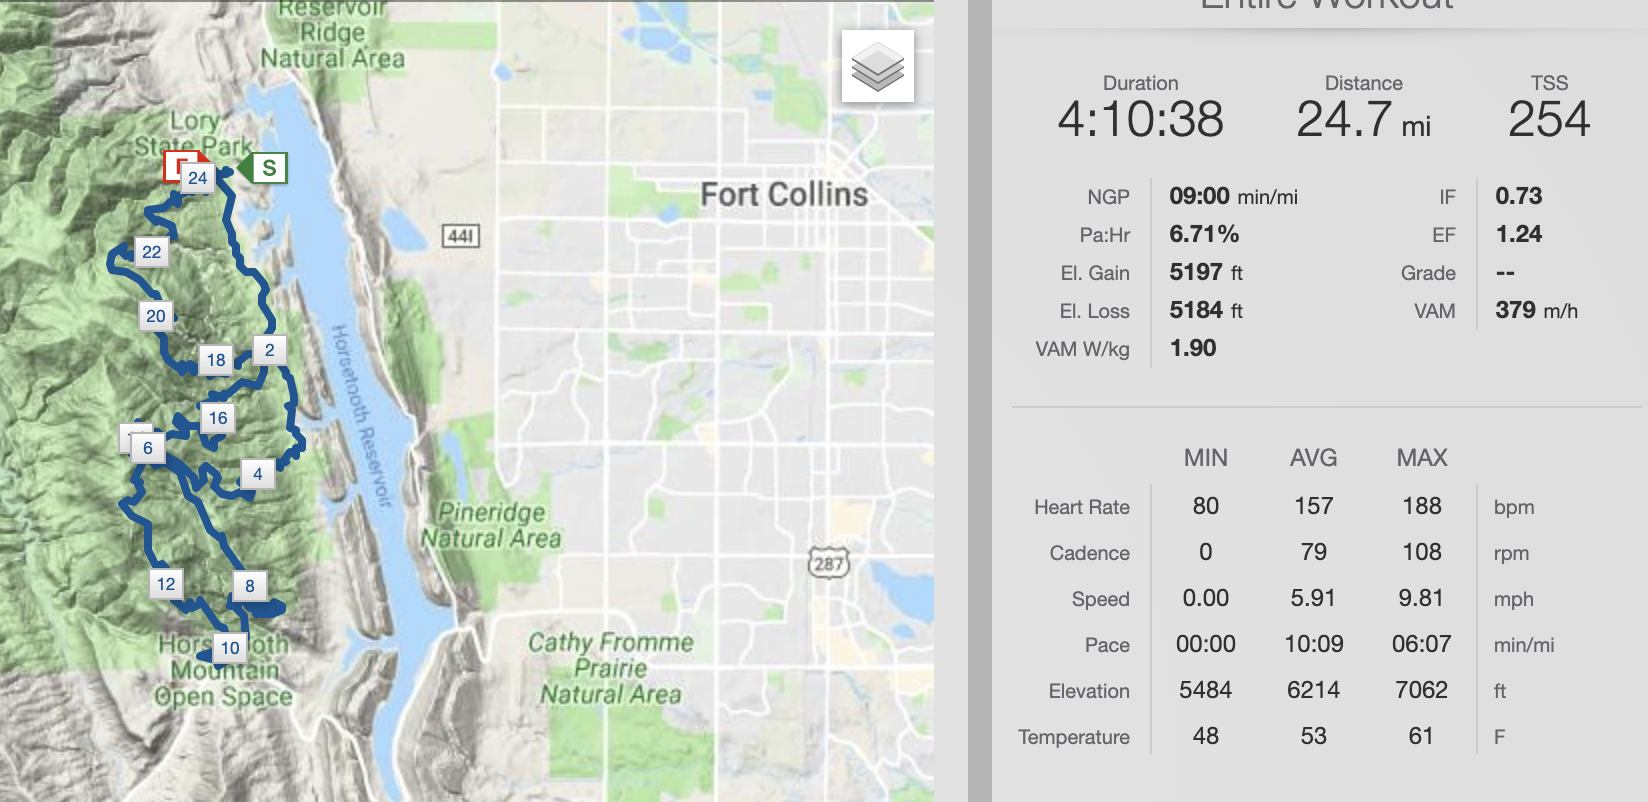

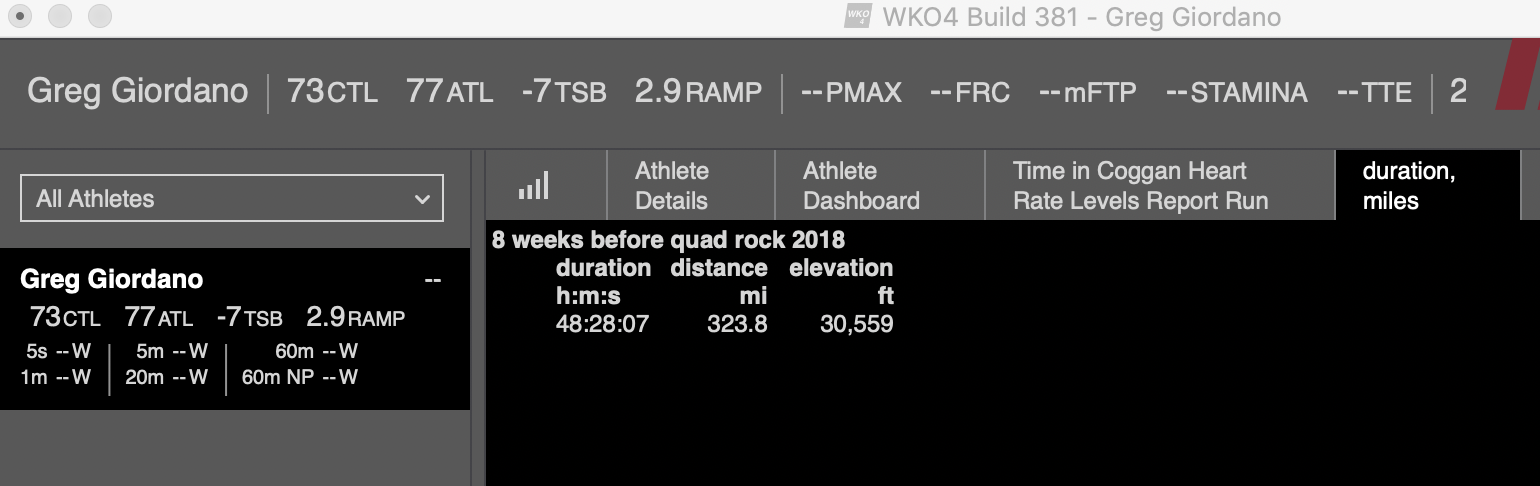

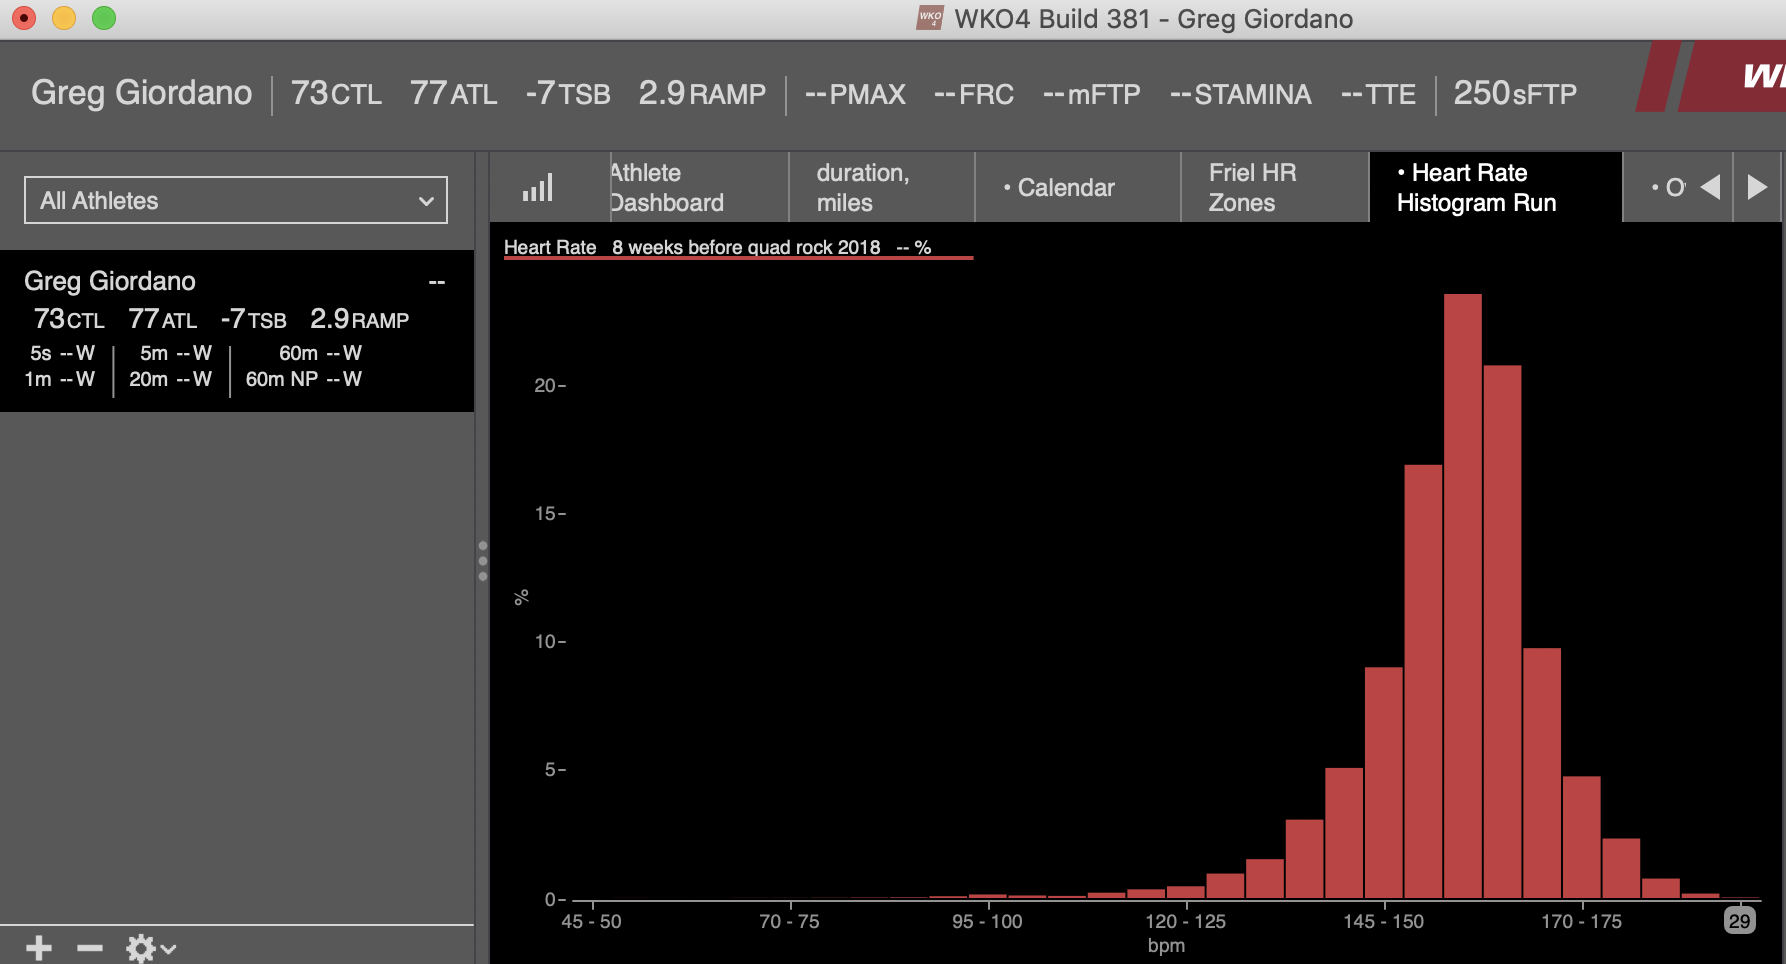

## Dataframe setup

### race variables
name: name of race, with distance and year  
time: y, race finish time, what I'm trying to predict, seconds   
distance: race distance, miles  
climbing: total elevation gain of race, feet  
road: road race = 1, trail race = 0, categorical  
avgAlt: average elevation of race, feet  
    
### training variables
miles8w: total distance run in 8 weeks before race, miles  
duration8w: total time run in 8 weeks before race, seconds  
climbing8w: total elevation gain in 8 weeks before race, feet  
thresHR8w: time spent with hr above 159 bpm in 8 weeks before race, seconds*  
thresPace8w: time spent running faster than 7:00 min/mile in 8 weeks before race*

*159 bpm and 7:00 min/mile were selected based on the Friel training zones. Generally, time spent at higher heart rates or faster paces than these may be seen as high intensity. So, these variables represent time spent exercising at high intensity as determined by either heart rate or pace.  
https://www.trainingpeaks.com/blog/joe-friel-s-quick-guide-to-setting-zones/



In [2]:
raceData = pd.read_csv('raceData.csv')
raceData.road = raceData.road.astype('category') #force category type for road variable
raceData.head()

,name,time,distance,climbing,road,avgAlt,miles8w,duration8w,climbing8w,thresHR8w,thresPace8w
0,QuadRock_25_2018,15038,24.70,5197.0,0,6214,353.6,189883,34105.0,84353.0,11212
1,Homecoming_3.1_2018,1153,3.12,79.0,1,5039,168.5,83145,8996.0,22969.0,4735
2,NeverSummer_62_2018,64309,65.49,10988.0,0,9817,389.7,224321,44657.0,70417.0,503
3,Liberty_3.1_2018,1107,3.11,49.0,1,4955,341.1,195257,37763.0,72773.0,2818
4,Homecoming_3.1_2017,1161,3.10,143.0,1,5214,201.8,103016,23534.0,69611.0,9634


## Cleaning data

### check for NaN

In [3]:
pd.isna(raceData)

,name,time,distance,climbing,road,avgAlt,miles8w,duration8w,climbing8w,thresHR8w,thresPace8w
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False


### cleaning up NaN

The variables missing are in the climbing8w and thresHR8w columns, likely because of different watch models with different capabilities being used over the time period. I don't want to drop any races because my n is so small. I don't think it makes sense to fill these NaN values with the column average because these values will be correlated with duration8w. Rather, I will create new columns relating duration to climbing8w and thresHR8w, the average of which I will use to fill the NaNs.

In [48]:
raceData['climb_dur8w'] = raceData['climbing8w'] / raceData['duration8w'] #new column
climb_dur = raceData['climb_dur8w'].mean()

raceData['thresHR_dur8w'] = raceData['thresHR8w'] / raceData['duration8w'] #new column
thresHR_dur = raceData['thresHR_dur8w'].mean()

raceData['thresPace_dur8w'] = raceData['thresPace8w'] / raceData['duration8w'] #new column

In [49]:
raceData['climb_dur8w'] = raceData['climb_dur8w'].fillna(climb_dur)
raceData['thresHR_dur8w'] = raceData['thresHR_dur8w'].fillna(thresHR_dur)

raceData['climbing8w'] = raceData['climbing8w'].fillna(round(raceData['duration8w'] * raceData['climb_dur8w']))
raceData['thresHR8w'] = raceData['thresHR8w'].fillna(round(raceData['duration8w'] * raceData['thresHR_dur8w']))

## Final dataframe

In [50]:
raceData

,name,time,distance,climbing,road,avgAlt,miles8w,duration8w,climbing8w,thresHR8w,thresPace8w,climb_dur8w,thresHR_dur8w,thresPace_dur8w
0,QuadRock_25_2018,15038,24.70,5197.0,0,6214,353.6,189883,34105.0,84353.0,11212,0.179611,0.444237,0.059047
1,Homecoming_3.1_2018,1153,3.12,79.0,1,5039,168.5,83145,8996.0,22969.0,4735,0.108197,0.276252,0.056949
2,NeverSummer_62_2018,64309,65.49,10988.0,0,9817,389.7,224321,44657.0,70417.0,503,0.199076,0.313912,0.002242
3,Liberty_3.1_2018,1107,3.11,49.0,1,4955,341.1,195257,37763.0,72773.0,2818,0.193402,0.372704,0.014432
4,Homecoming_3.1_2017,1161,3.10,143.0,1,5214,201.8,103016,23534.0,69611.0,9634,0.228450,0.675730,0.093519
5,Dirty_30_2017,21859,31.75,7465.0,0,8719,408.8,212539,57511.0,117790.0,15563,0.270590,0.554204,0.073224
6,QuadRock_25_2017,15977,25.05,4823.0,0,6240,401.1,207082,54556.0,117304.0,15464,0.263451,0.566462,0.074676
7,Equinox_13.1_2016,4891,13.13,0.0,1,5536,331.2,156573,23655.0,38174.0,21096,0.151080,0.243810,0.134736
8,BBoulder_6.2_2016,2270,6.30,171.0,1,5356,250.9,116948,19518.0,39882.0,16957,0.166895,0.341023,0.144996
9,Colorado_13.1_2016,5049,13.27,77.0,1,5150,306.8,150766,28967.0,40830.0,14349,0.192132,0.270817,0.095174


## Exploratory Data Analysis

### race variables
You can see the variability of the data below, with each variable containing several outliers. I'd like to keep the outliers for the time being, given the small n.

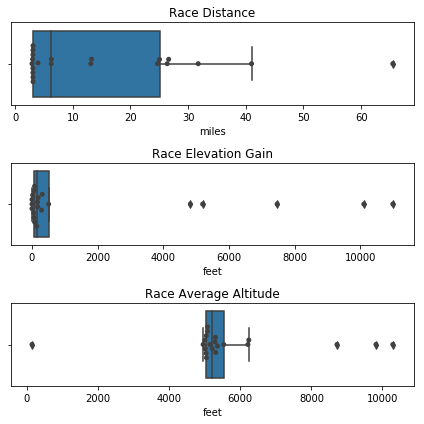

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharey=False,figsize=(6,6))

box1 = sns.boxplot(x=raceData['distance'],ax=ax1).set_title('Race Distance')
swarm1 = sns.swarmplot(x=raceData['distance'], color=".25",ax=ax1)
ax1.set_xlabel("miles")

box2 = sns.boxplot(x=raceData['climbing'],ax=ax2).set_title('Race Elevation Gain')
swarm2 = sns.swarmplot(x=raceData['climbing'], color=".25",ax=ax2)
ax2.set_xlabel("feet")

box3 = sns.boxplot(x=raceData['avgAlt'],ax=ax3).set_title('Race Average Altitude')
swarm3 = sns.swarmplot(x=raceData['avgAlt'], color=".25",ax=ax3)
ax3.set_xlabel("feet")

plt.tight_layout()

### number of races in dataset by categorical road variable
The type of race (road or trail) will likely have a great influence on the the race variables, so it may be useful to compare these by race type.

Text(0.5, 1.0, 'Road or Trail Race')

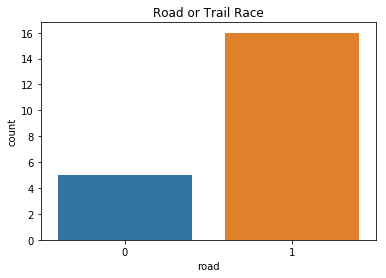

In [8]:
sns.countplot(x=raceData['road']).set_title('Road or Trail Race')

### differences between road and trail races
The following graphs show the differences between road and trail races. The trail races tend to be of greater distances, involve greater elevation gain, and take place at higher altitudes. 

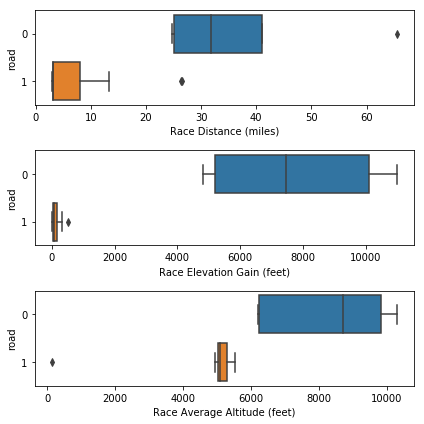

In [9]:
fig2, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharey=False,figsize=(6,6))


cat1 = sns.catplot(x='distance',y='road', kind='box', ax=ax1, data=raceData)
ax1.set_xlabel("Race Distance (miles)")

cat2 = sns.catplot(x='climbing',y='road', kind='box', ax=ax2, data=raceData)
ax2.set_xlabel("Race Elevation Gain (feet)")

cat3 = sns.catplot(x='avgAlt',y='road', kind='box', ax=ax3, data=raceData)
ax3.set_xlabel("Race Average Altitude (feet)")


plt.close(cat1.fig)
plt.close(cat2.fig)
plt.close(cat3.fig)

plt.tight_layout()

### training variables

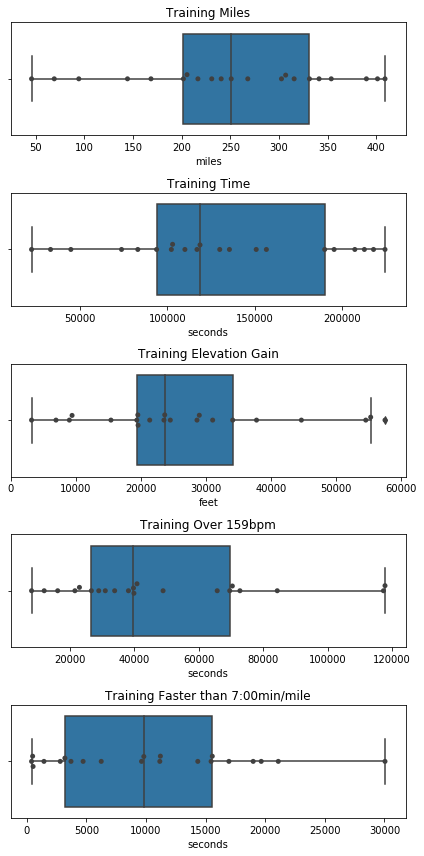

In [10]:
fig3, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, sharey=False,figsize=(6,12))

box1 = sns.boxplot(x=raceData['miles8w'],ax=ax1).set_title('Training Miles')
swarm1 = sns.swarmplot(x=raceData['miles8w'], color=".25",ax=ax1)
ax1.set_xlabel("miles")

box2 = sns.boxplot(x=raceData['duration8w'],ax=ax2).set_title('Training Time')
swarm2 = sns.swarmplot(x=raceData['duration8w'], color=".25",ax=ax2)
ax2.set_xlabel("seconds")

box3 = sns.boxplot(x=raceData['climbing8w'],ax=ax3).set_title('Training Elevation Gain')
swarm3 = sns.swarmplot(x=raceData['climbing8w'], color=".25",ax=ax3)
ax3.set_xlabel("feet")

box4 = sns.boxplot(x=raceData['thresHR8w'],ax=ax4).set_title('Training Over 159bpm')
swarm4 = sns.swarmplot(x=raceData['thresHR8w'], color=".25",ax=ax4)
ax4.set_xlabel("seconds")

box5 = sns.boxplot(x=raceData['thresPace8w'],ax=ax5).set_title('Training Faster than 7:00min/mile')
swarm5 = sns.swarmplot(x=raceData['thresPace8w'], color=".25",ax=ax5)
ax5.set_xlabel("seconds")

plt.tight_layout()


### differences in road vs. trail training
Training variables also appear to vary by type of race, with trail training seeming to involve more distance, time, and high intensity time as determined by heart rate.  

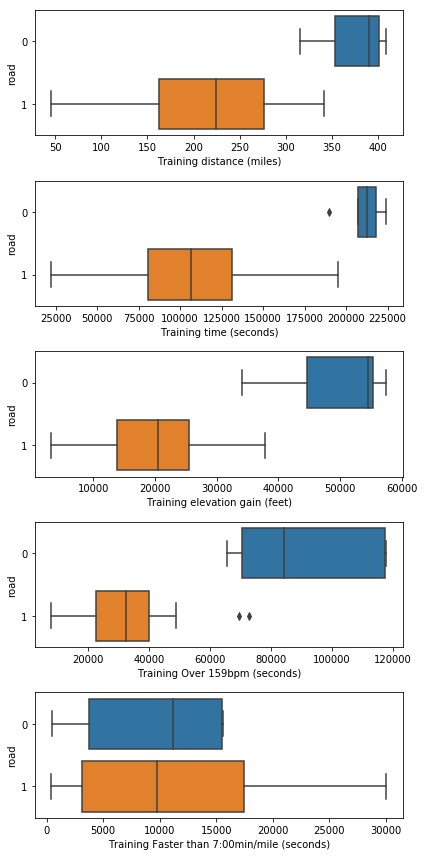

In [11]:
fig4, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, sharey=False,figsize=(6,12))

cat1 = sns.catplot(x='miles8w',y='road', kind='box', ax=ax1, data=raceData)
ax1.set_xlabel("Training distance (miles)")

cat2 = sns.catplot(x='duration8w',y='road', kind='box', ax=ax2, data=raceData)
ax2.set_xlabel("Training time (seconds)")

cat3 = sns.catplot(x='climbing8w',y='road', kind='box', ax=ax3, data=raceData)
ax3.set_xlabel("Training elevation gain (feet)")

cat4 = sns.catplot(x='thresHR8w',y='road', kind='box', ax=ax4, data=raceData)
ax4.set_xlabel("Training Over 159bpm (seconds)")

cat5 = sns.catplot(x='thresPace8w',y='road', kind='box', ax=ax5, data=raceData)
ax5.set_xlabel("Training Faster than 7:00min/mile (seconds)")

plt.close(cat1.fig)
plt.close(cat2.fig)
plt.close(cat3.fig)
plt.close(cat4.fig)
plt.close(cat5.fig)

plt.tight_layout()

### pair plots of data

The pair plot of the data below suggest some correlations between the predictors. Unsurprisingly, there appear to be positive correlations between training duration and other training variables such as climbing and mileage. 

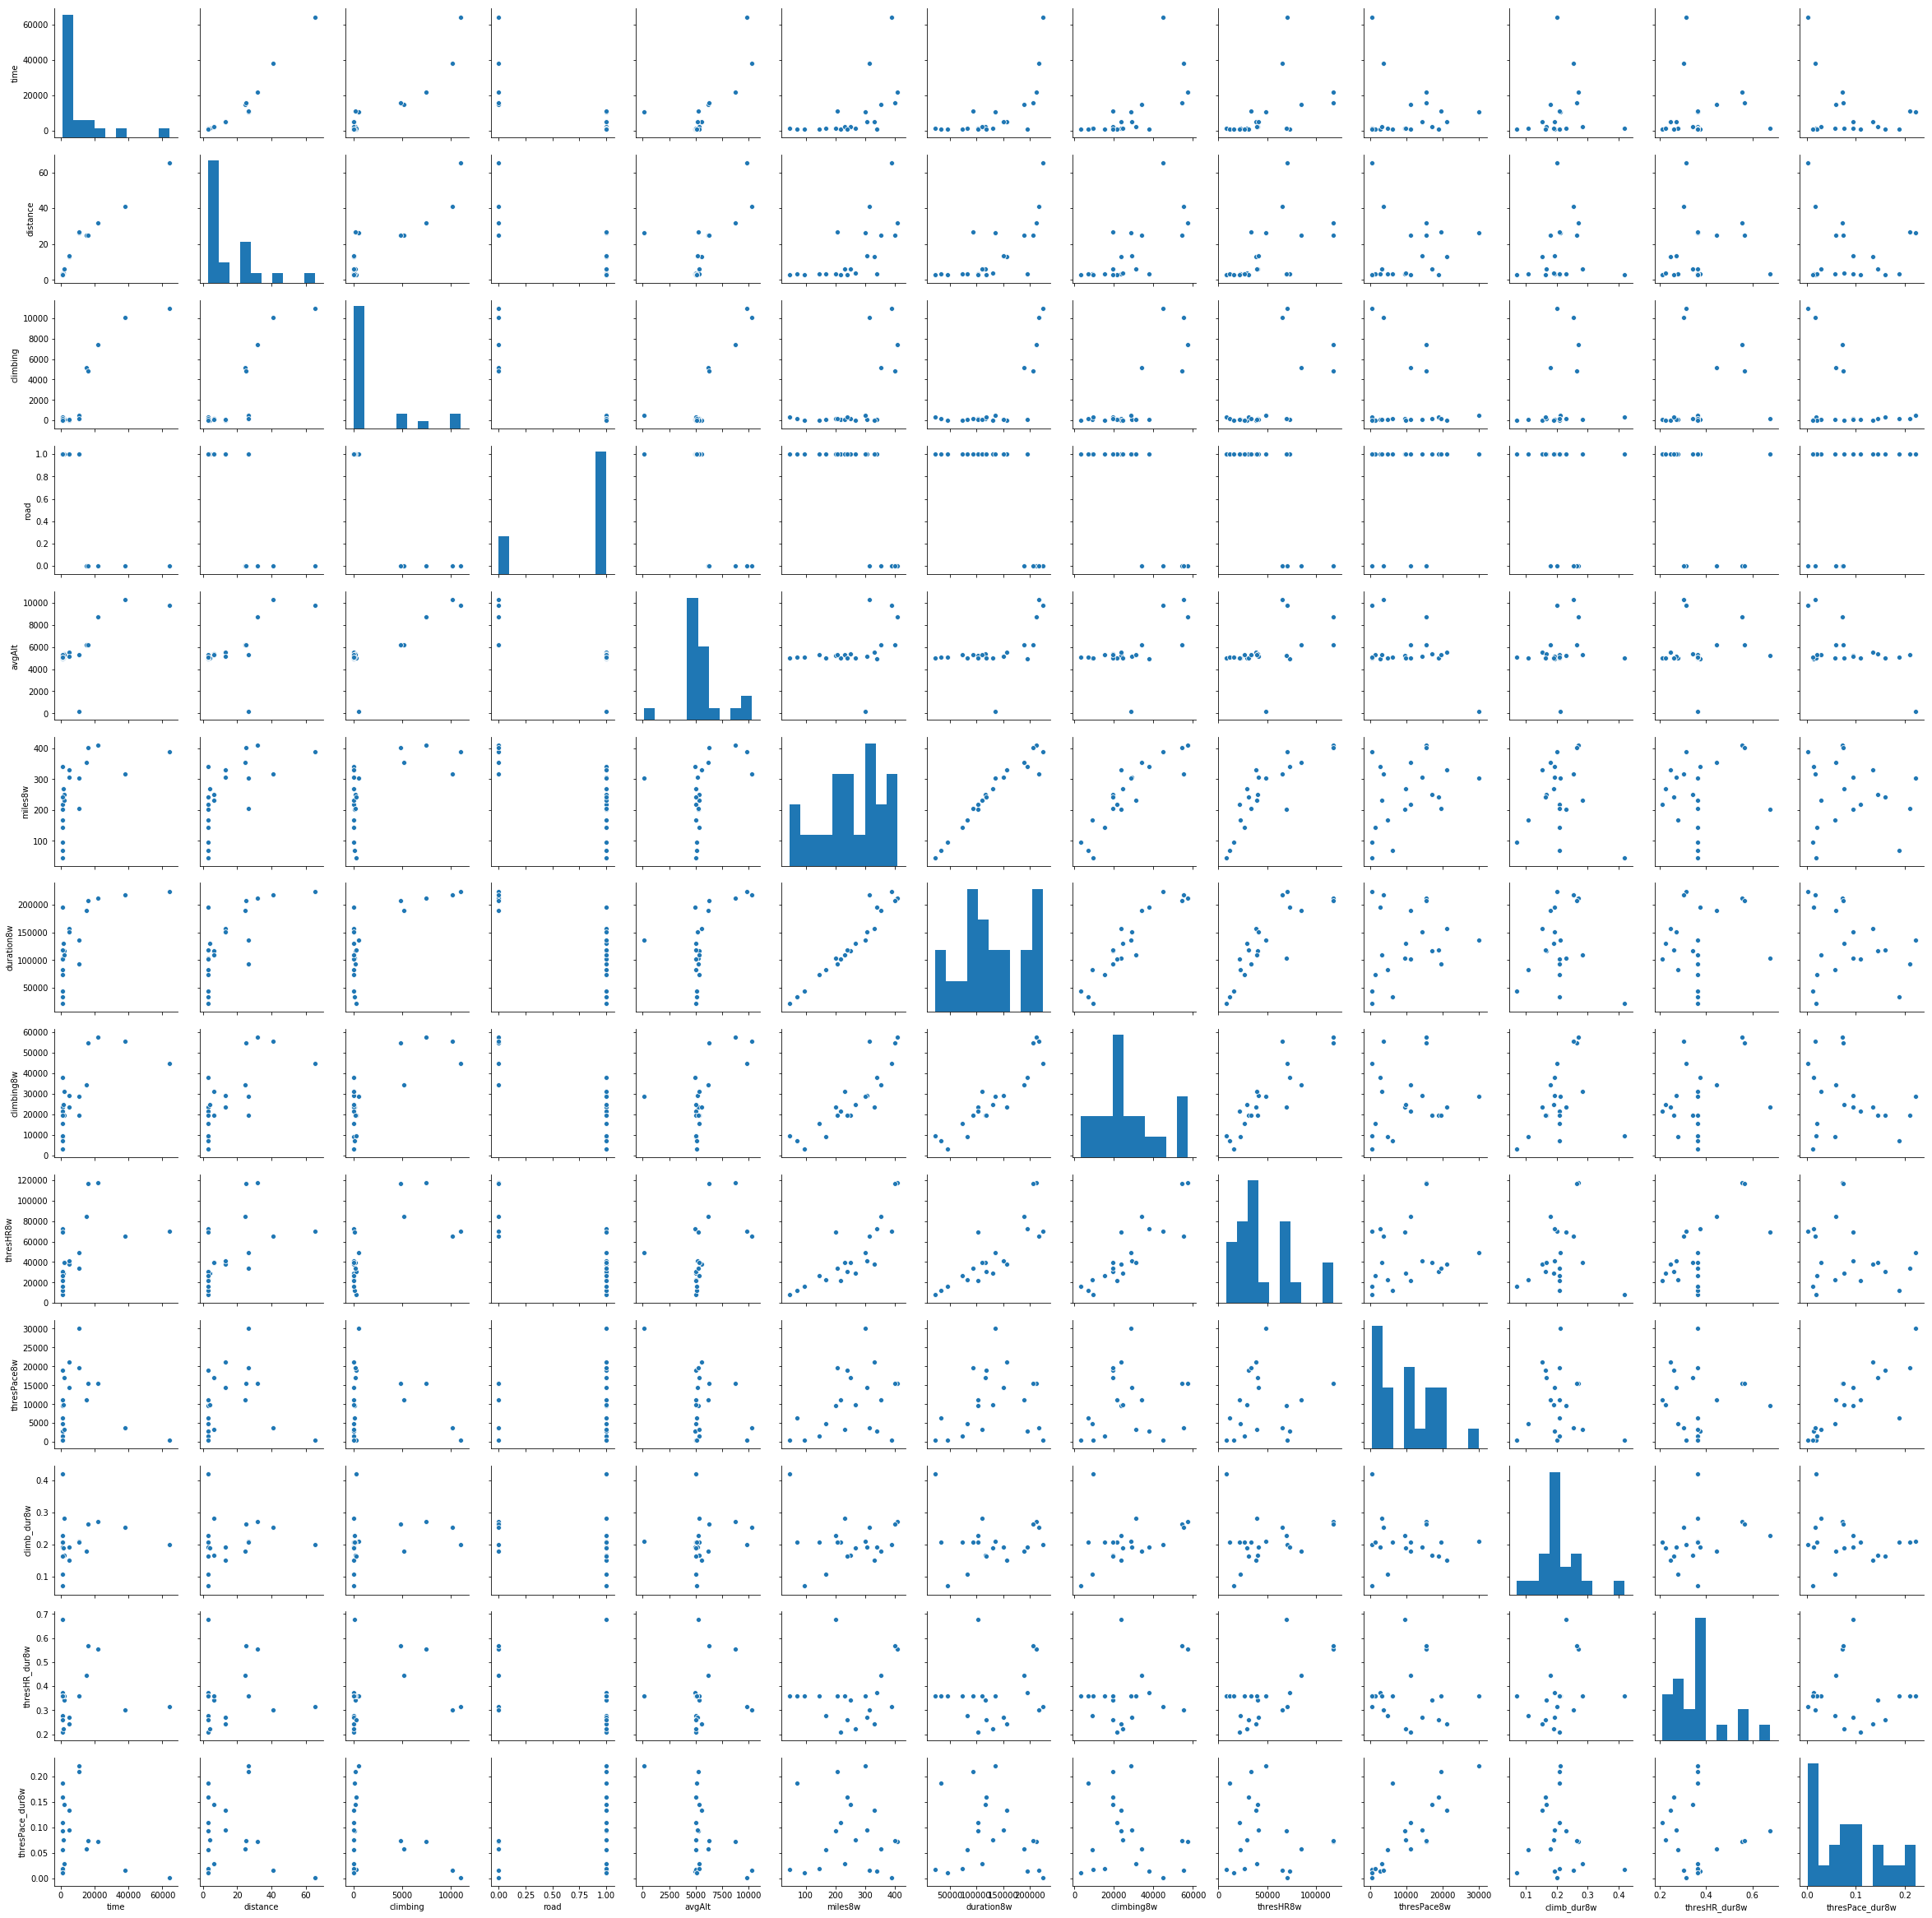

In [12]:
sns.pairplot(raceData)

### pair plot split by categorical road variable  
orange = road races  
blue = trail races  

/Users/greggior/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/greggior/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/greggior/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/greggior/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, *

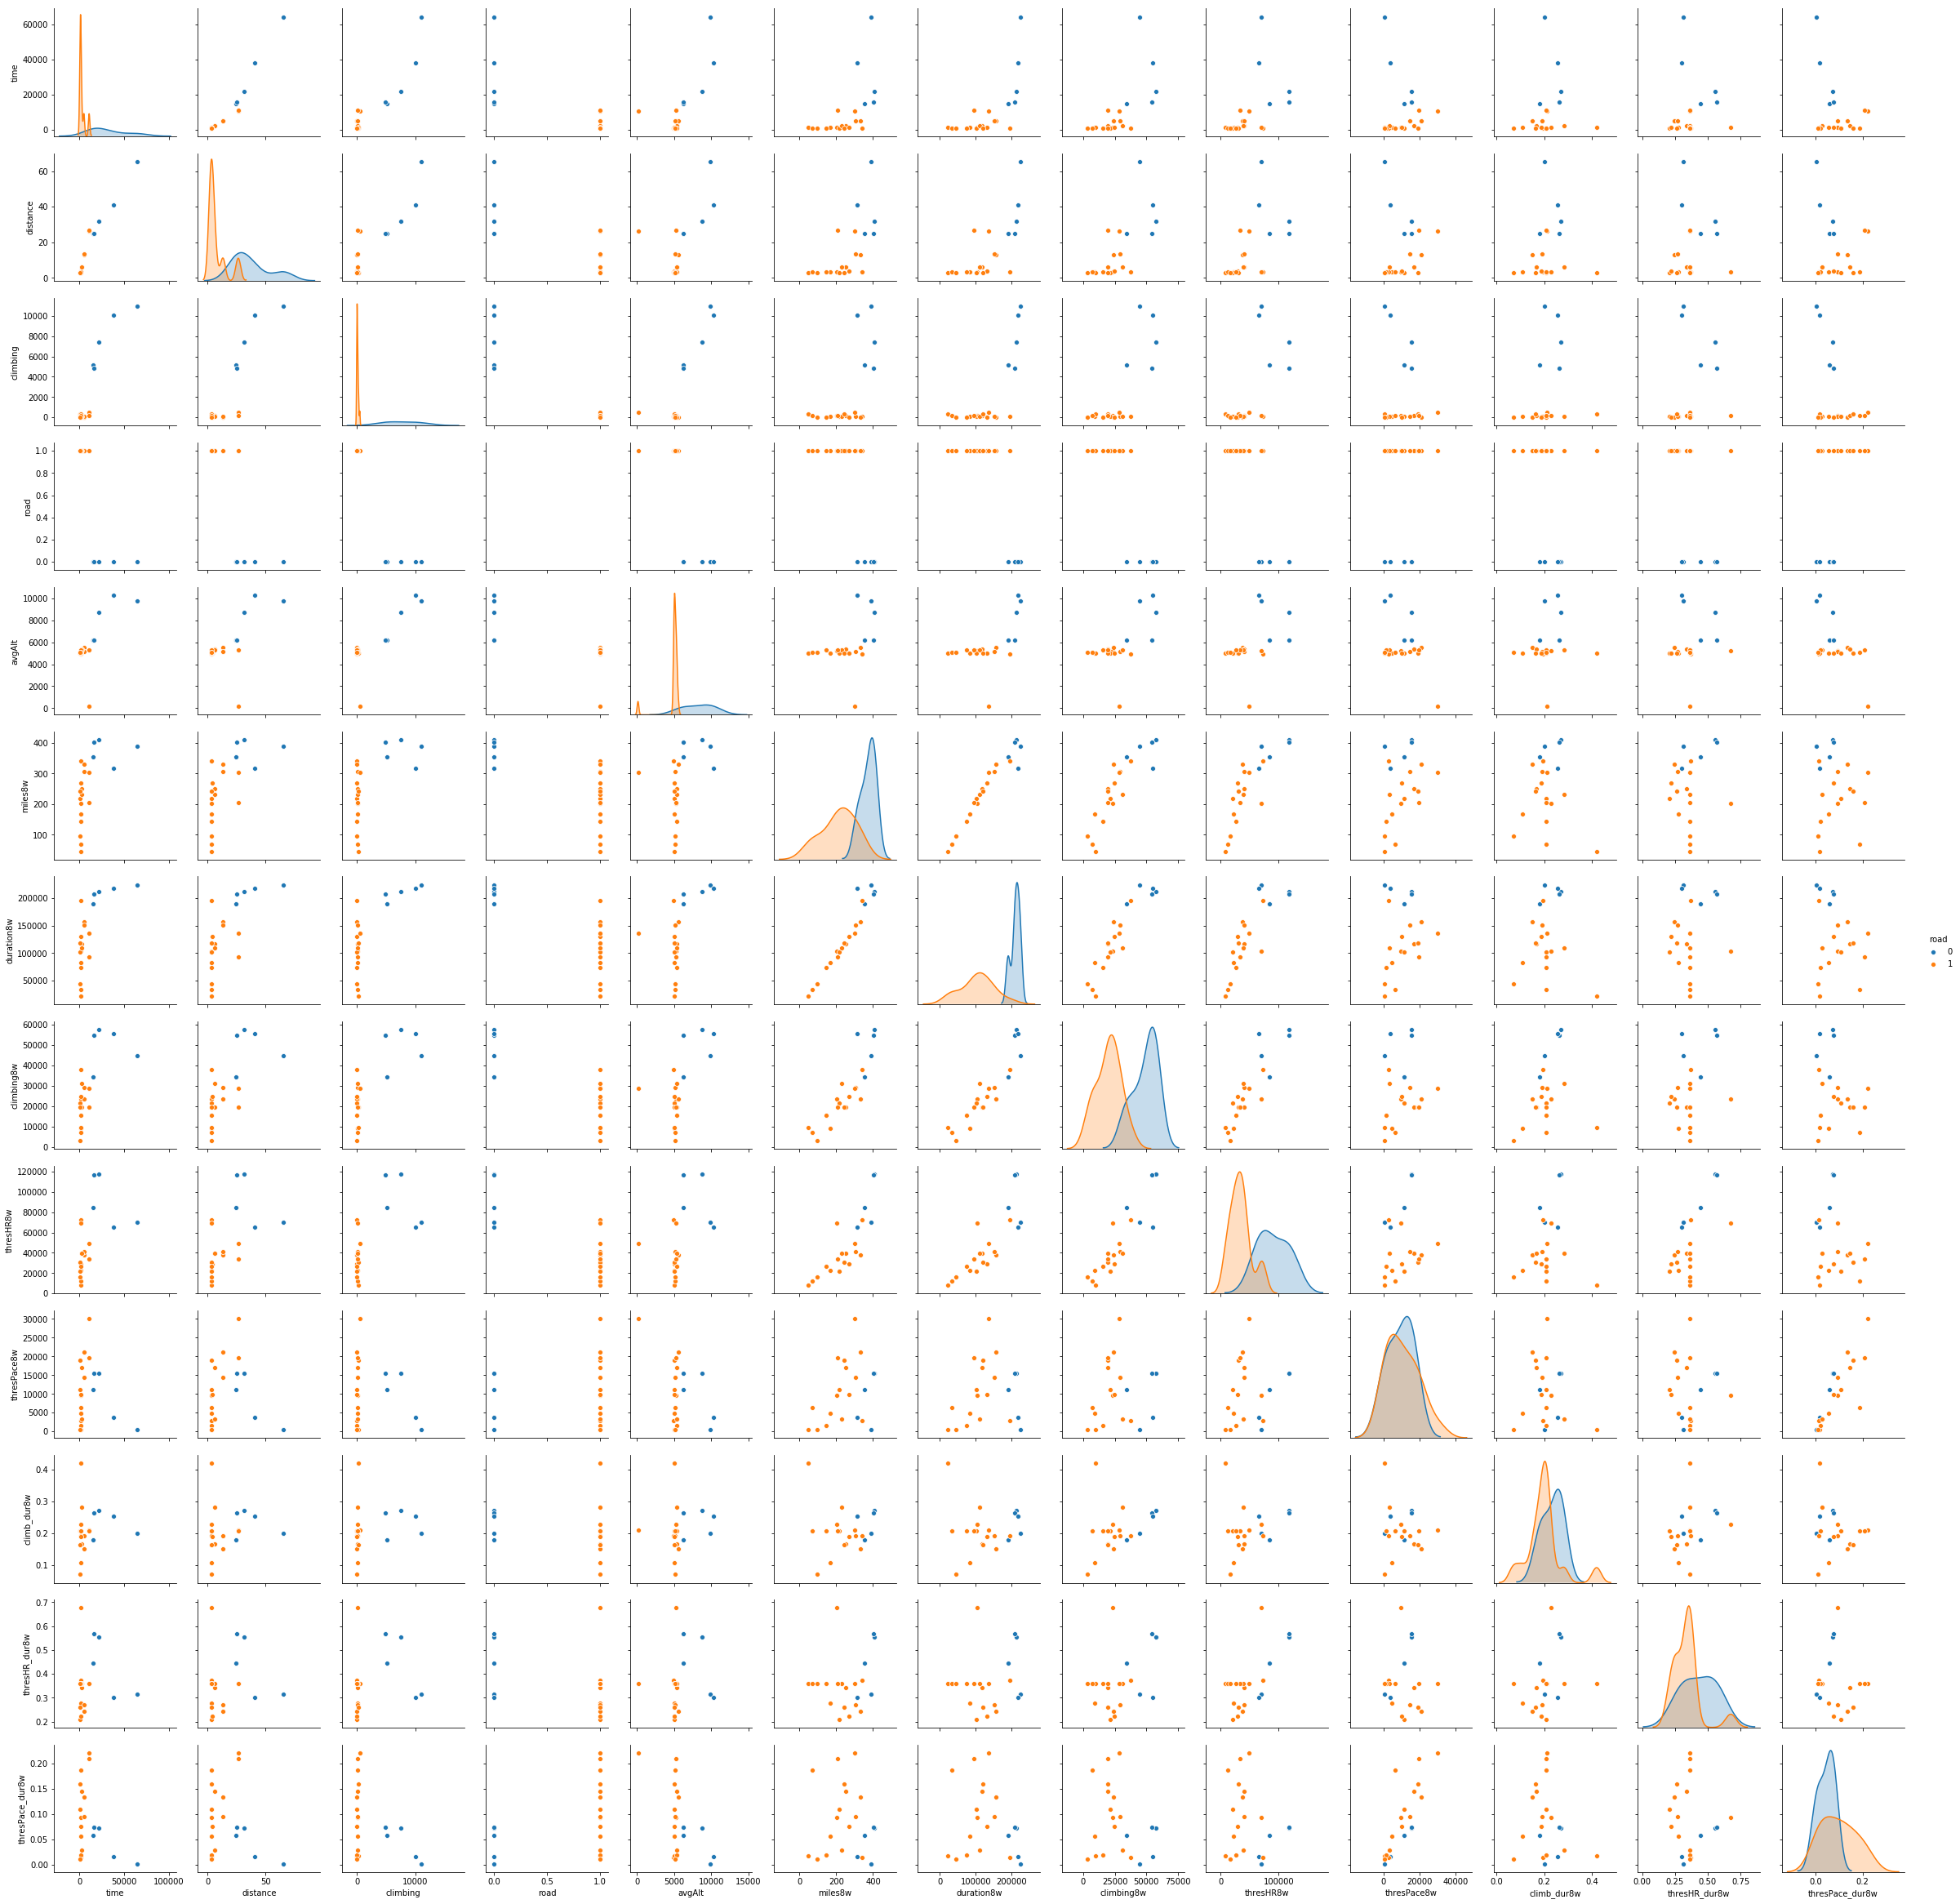

In [13]:
sns.pairplot(raceData, hue='road')

### prediction
The original goal of the project is prediction. The data is split into training and testing subsets for this purpose. Given the shown differences between road and trail races, I made sure to pull both road and trail races into both the training and testing subsets. I used a manual forward stepwise selection to find the best model. The race variables(distance, climbing, road) are the strongest predictors of race finish time, which is intuitive. I'm most interested in what training variables predict finish time. Interestingly, none of the training variables alone are significant in the model. However, the interaction between duration and high intensity training is significant.

In [58]:
roadRaceData = raceData[raceData['road'] == 1] #road races
trailRaceData = raceData[raceData['road'] == 0] #trail races

trainRoad = roadRaceData[0::2] #training subset of road races
trainTrail = trailRaceData[0::2] #training subset of trail races
trainBoth = trainRoad.append(trainTrail) #combine training sets

testRoad = roadRaceData[1::2] #test subset of road races
testTrail = trailRaceData[1::2] #test subset of trail races
testBoth = testRoad.append(testTrail) #combine test sets

In [63]:
racePred = smf.ols('time~distance+climbing+road+duration8w*thresPace8w', data=trainBoth).fit()
print(racePred.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1058.
Date:                Wed, 08 May 2019   Prob (F-statistic):           2.38e-06
Time:                        18:57:20   Log-Likelihood:                -77.844
No. Observations:                  11   AIC:                             169.7
Df Residuals:                       4   BIC:                             172.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -9645

/Users/greggior/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [81]:
predictions = racePred.predict(testBoth).values
true = testBoth['time'].values

for thing1, thing2 in zip(predictions, true):
    print('Predicted: ' + str(thing1))
    print('Actual: ' + str(thing2))

print("")
print("RSS: " + str(np.sum(racePred.resid**2)))

Predicted: 1974.9570218565793
Actual: 1107
Predicted: 2003.2109851346313
Actual: 4891
Predicted: 3758.321970973294
Actual: 5049
Predicted: 851.5724456579865
Actual: 1433
Predicted: 683.7484063245956
Actual: 1072
Predicted: 8577.933805356448
Actual: 10761
Predicted: 897.0540884438473
Actual: 1116
Predicted: 348.08039924575814
Actual: 1084
Predicted: 51470.50546525113
Actual: 64309
Predicted: 12166.394757813494
Actual: 15977

RSS: 902997.1010711666


### diagnostic plots
The residuals appear to be normally distributed.  

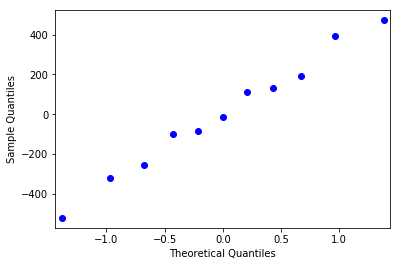

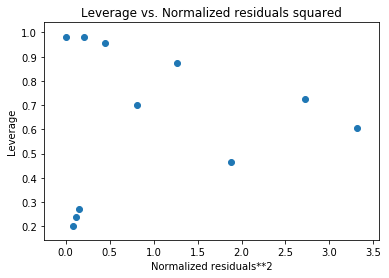

In [79]:
sm.qqplot(racePred.resid);
sm.graphics.plot_leverage_resid2(racePred, alpha=0.05);

### inference
Given the limited dataset, and the splitting of the dataset required to test the data, I decided to do some inference work in order to be able to explore a model with all of the available data.

### simple linear regression
Distance is the best predictor of time for a race, which is to be expected. The resulting model's coefficient for distance suggests that for every 1 mile increase in distance, time will increase by ~800 seconds. So, after the negative intercept is accounted for, the model suggests 13:00 min/miles, resulting in it overestimating times particularly for road races 10k-26.2miles. 

In [21]:
raceSimplePred = smf.ols('time~distance', data=raceData).fit()
print(raceSimplePred.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     232.3
Date:                Wed, 08 May 2019   Prob (F-statistic):           4.16e-12
Time:                        18:31:57   Log-Likelihood:                -204.95
No. Observations:                  21   AIC:                             413.9
Df Residuals:                      19   BIC:                             416.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3744.4547   1303.085     -2.874      0.0

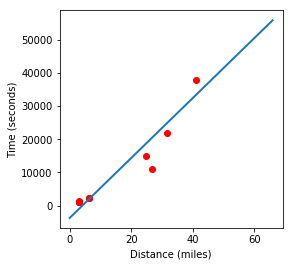

In [23]:
plt.figure(figsize=(4,4))
plt.plot(trainBoth.distance, trainBoth.time, 'ro');

beta0,beta1 = raceSimplePred.params

xticks = np.linspace(0,66,10)
plt.plot(xticks, beta0 + beta1 * xticks, lw=2)

plt.xlabel('Distance (miles)')
plt.ylabel('Time (seconds)');

In [24]:
print("RSS: " + str(np.sum(raceSimplePred.resid**2)))

RSS: 368751815.5457638


### two predictors
The model is improved by including elevation gain.

In [25]:
raceTwoPred = smf.ols('time~distance+climbing', data=raceData).fit()
print(raceTwoPred.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     174.9
Date:                Wed, 08 May 2019   Prob (F-statistic):           1.61e-12
Time:                        18:32:18   Log-Likelihood:                -200.38
No. Observations:                  21   AIC:                             406.8
Df Residuals:                      18   BIC:                             409.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2421.4629   1156.743     -2.093      0.0

In [71]:
beta0,beta1,beta2 = raceTwoPred.params

dist = np.arange(0,100,1)
climb = np.arange(0,100,1)

B1, B2 = np.meshgrid(dist, climb, indexing='xy')
Z = np.zeros((dist.size, climb.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(beta0 + B1[i,j]*beta2 + B2[i,j]*beta1)

RSS: 238606390.7860381


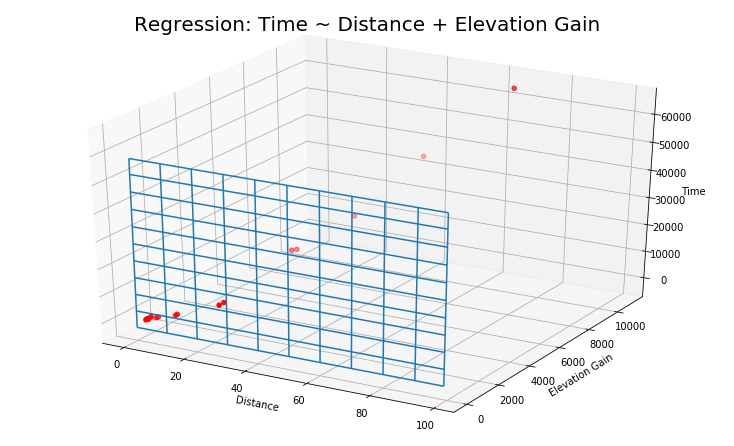

In [82]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: Time ~ Distance + Elevation Gain', fontsize=20)

ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z, rstride=10, cstride=10)
ax.scatter3D(raceData.distance, raceData.climbing, raceData.time, c='r')

ax.set_xlabel('Distance')
ax.set_ylabel('Elevation Gain')
ax.set_zlabel('Time');

print("RSS: " + str(np.sum(raceTwoPred.resid**2)))

### more than 2 predictors
The model is again improved by including high intensity training (pace).

In [32]:
racePred = smf.ols('time~distance+climbing+road+thresPace8w', data=raceData).fit()
print(racePred.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     273.5
Date:                Wed, 08 May 2019   Prob (F-statistic):           1.65e-14
Time:                        18:33:06   Log-Likelihood:                -187.54
No. Observations:                  21   AIC:                             385.1
Df Residuals:                      16   BIC:                             390.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.245e+04   3647.777     -3.414      

In [34]:
print("RSS: " + str(np.sum(racePred.resid**2)))

RSS: 70280663.46889588


### just road races
### simple linear regression
Simple linear regression, and all of the models below fit much better if only road races are included in the dataset. Rather than ~13:00min/miles, simple linear regression with only road races results in just under ~7min/miles.

In [35]:
simpleRoadPred = smf.ols('time~distance', data=roadRaceData).fit()
print(simpleRoadPred.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     8536.
Date:                Wed, 08 May 2019   Prob (F-statistic):           6.61e-21
Time:                        18:33:37   Log-Likelihood:                -100.59
No. Observations:                  16   AIC:                             205.2
Df Residuals:                      14   BIC:                             206.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -184.8311     48.891     -3.780      0.0

/Users/greggior/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


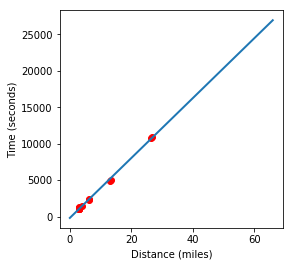

In [36]:
plt.figure(figsize=(4,4))
plt.plot(roadRaceData.distance, roadRaceData.time, 'ro');

beta0,beta1 = simpleRoadPred.params

xticks = np.linspace(0,66,10)
plt.plot(xticks, beta0 + beta1 * xticks, lw=2)

plt.xlabel('Distance (miles)')
plt.ylabel('Time (seconds)');

In [37]:
print("RSS: " + str(np.sum(simpleRoadPred.resid**2)))

RSS: 270753.58898642415


## road two predictors

In [38]:
twoRoadPred = smf.ols('time~distance+climbing', data=roadRaceData).fit()
print(twoRoadPred.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5861.
Date:                Wed, 08 May 2019   Prob (F-statistic):           6.15e-20
Time:                        18:33:45   Log-Likelihood:                -97.468
No. Observations:                  16   AIC:                             200.9
Df Residuals:                      13   BIC:                             203.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -228.4012     45.244     -5.048      0.0

/Users/greggior/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


In [41]:
beta0,beta1,beta2 = twoRoadPred.params

dist = np.arange(0,50,1)
climb = np.arange(0,50,1)

B1, B2 = np.meshgrid(dist, climb, indexing='xy')
Z = np.zeros((dist.size, climb.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(beta0 + B1[i,j]*beta2 + B2[i,j]*beta1)

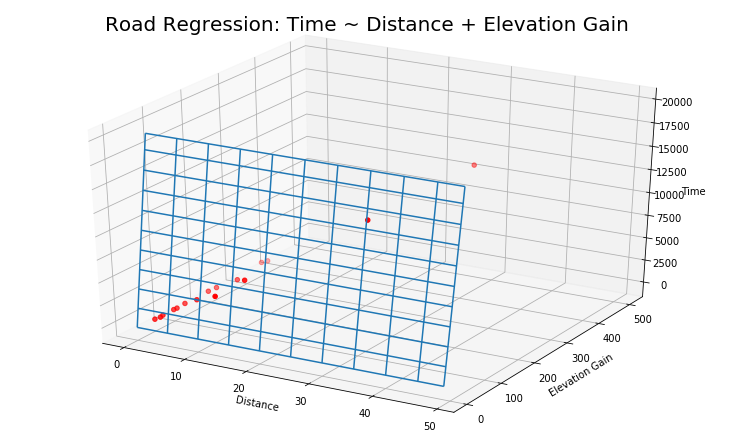

In [67]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Road Regression: Time ~ Distance + Elevation Gain', fontsize=20)

ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z, rstride=5, cstride=5)
ax.scatter3D(roadRaceData.distance, roadRaceData.climbing, roadRaceData.time, c='r')

ax.set_xlabel('Distance')
ax.set_ylabel('Elevation Gain')
ax.set_zlabel('Time');

In [47]:
print("RSS: " + str(np.sum(twoRoadPred.resid**2)))

RSS: 183180.140844209


### road three predictors

In [95]:
roadRacePred3 = smf.ols('time~distance+climbing+thresPace8w', data=roadRaceData).fit()
print(roadRacePred3.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     7417.
Date:                Wed, 08 May 2019   Prob (F-statistic):           7.19e-20
Time:                        20:56:29   Log-Likelihood:                -91.706
No. Observations:                  16   AIC:                             191.4
Df Residuals:                      12   BIC:                             194.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -180.8725     35.462     -5.101      

/Users/greggior/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


In [96]:
print("RSS: " + str(np.sum(roadRacePred3.resid**2)))

RSS: 89135.99392467403


### wrap up
I enjoyed working on this project. I was excited to see that one of the high intensity training variables was significant in a few of the models above with a negative coefficient. I would like to have access to additional data from more people to work with, as my n was so small. I've found race results datasets online, which might be used to look for optimal pacing strategies, but I'm most interested in how training relates to performance. I created another dataset that breaks down races of similar length into one mile increments as a means to increase the my n, but I've run out of time to explore that data. Another interesting direction could be a classification study to classify runs as either on the road or on the trail based on pace and elevation gain, but also other data like running cadence.